#Import the required packages 

**In Class Programming-11(UNET)**

1.  Make 4 changes(for example changing number of layers, changing hyper parameters,
adding more cell blocks to bottle neck layer etc) to U-NET architecture given in the source code
and train it on the same (or different) data set. 
2.  Justify your changes by providing explanations
in the report for each of the change you made. Visualize model performance and compare any
difference you noticed in model performance.

In [1]:
import tensorflow as tf
import os
import sys
import cv2
import random
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras import backend as K
import matplotlib.pyplot as plt


## Mount the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
pwd

'/content'

#Install kaggle package to get the datasets

In [4]:
! pip install -q kaggle

### Important: 
 We will be using Kaggle data for this ICP and we need to integrate kaggle with colab please use the instruction here https://www.kaggle.com/general/74235 
 First sign upinto Kaggle (you can sign in with your google mail) >>> go to profile >> accounts>> click on create new API token. 
 This is download kaggle.jason file on your local machine

upload the kaagle.json file you created earlier 

In [15]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sivakumar471","key":"9f8a98634132c964ae9b30cc0a6ed193"}'}

### Copy the json file into directory

In [16]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### owner has full read and write access to the file, while no other user can access the file

In [17]:
! chmod 600 ~/.kaggle/kaggle.json

### List the kaggle datasets 

In [18]:
! kaggle datasets list

ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  -----------------------------------------------  ------  -------------------  -------------  
unanimad/us-election-2020                               US Election 2020                                  428KB  2020-11-20 10:47:51           6899  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University          3MB  2020-11-20 06:04:06           3165  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                           353MB  2020-11-09 18:51:59           3051  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates           199MB  2020-10-23 16:56:10            567  
etsc9287/2020-general-election-polls                    Election, COVID, and Demographic Data by Cou

### Download the datascience bowl 2018 dataset from kaggle with proper agrements and conditions. 

dowlowad the data set by executing the following code

### Current version of Kaggle 

In [19]:
!kaggle competitions  download -c data-science-bowl-2018

  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 56.4MB/s]
 88% 8.00M/9.10M [00:00<00:00, 83.8MB/s]
100% 9.10M/9.10M [00:00<00:00, 84.0MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.1MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.70MB/s]
 96% 265M/276M [00:02<00:00, 87.3MB/s]
100% 276M/276M [00:03<00:00, 95.8MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 123MB/s]
 82% 65.0M/79.1M [00:00<00:00, 97.7MB/s]
100% 79.1M/79.1M [00:00<00:00, 116MB/s] 


In [20]:
!kaggle -v

Kaggle API 1.5.4


### create a new directory to unzip the data 

In [21]:
! mkdir train

## unzip the data file

## Dataset: 

In this ICP, we use nuclei dataset from Kaggle. This dataset contains a large number of segmented nuclei images. Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:
images contains the image file.
masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).

In [22]:
! unzip /content/stage1_train.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/341193ff7f035f118eabe993464e402c5485ff014e095ff5e940a0

In [23]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

DATA_PATH = '/content/train/'


seed = 42
random.seed = seed
np.random.seed = seed

image_ids = next(os.walk(DATA_PATH))[1]

X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = DATA_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), )
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask

x_train=X

y_train=Y

100%|██████████| 670/670 [01:11<00:00,  9.38it/s]


U-Net, supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators. Hence, these layers increase the resolution of the output. In order to localize, high-resolution features from the contracting path are combined with the upsampled output. A successive convolution layer can then learn to assemble a more precise output based on this information. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. Such a network can be trained end-to-end from very few images.


U-Net consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3×3 convolutions, each followed by ReLU and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step, It doubles the number of feature channels.

Every step in the expansive path consists of an upsampling of the
feature map followed by a 2×2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3×3 convolutions, each followed by a ReLU.

At the final layer a 1×1 convolution is used to map each 64-component feature vector to the desired number of classes.

In [24]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c0 = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(s)
c0 = tf.keras.layers.Dropout(0.3)(c0)
c0 = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c0)
p0 = tf.keras.layers.MaxPooling2D((2, 2))(c0)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p0)
c1 = tf.keras.layers.Dropout(0.3)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.3)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.3)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.3)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c6)


u61 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
u61 = tf.keras.layers.concatenate([u61, c3])
c61 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u61)
c61 = tf.keras.layers.Dropout(0.3)(c61)
c61 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c61)


u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c61)
u7 = tf.keras.layers.concatenate([u7, c2])
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c7)


u8 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c1])
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.3)(c8)
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c0], axis=3)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u9)
                            
c9 = tf.keras.layers.Dropout(0.3)(c9)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c9)

                      

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In segmentation problems accuracy sometime can be a misleading and therefore a more reliable paramete, Dice score, is used to evaluate the model performance

In [25]:
def dice_acc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

compiling the model

In [26]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[dice_acc])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 8)  0           conv2d[0][0]                     
_______________________________________________________________________________________

For training, input images and their corresponding segmentation maps are used to train the network

In [62]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss', verbose=1),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]

results = model.fit(x_train, y_train, validation_split=0.2, batch_size=64, epochs=30,callbacks=callbacks)

Epoch 1/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0701 - dice_acc: 0.8744
Epoch 00001: saving model to training_1/cp.ckpt
9/9 [==============================] - 1s 111ms/step - loss: 0.0697 - dice_acc: 0.8762 - val_loss: 0.0879 - val_dice_acc: 0.8639
Epoch 2/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0633 - dice_acc: 0.8864
Epoch 00002: saving model to training_1/cp.ckpt
9/9 [==============================] - 1s 88ms/step - loss: 0.0634 - dice_acc: 0.8861 - val_loss: 0.1003 - val_dice_acc: 0.8538
Epoch 3/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0690 - dice_acc: 0.8767
Epoch 00003: saving model to training_1/cp.ckpt
9/9 [==============================] - 1s 88ms/step - loss: 0.0691 - dice_acc: 0.8772 - val_loss: 0.0879 - val_dice_acc: 0.8768
Epoch 00003: early stopping


visualizing the model performance

1/1 [==============================] - 0s 3ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


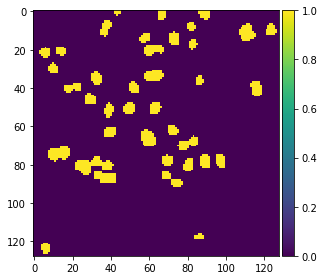

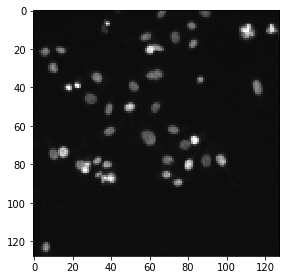

1/1 [==============================] - 0s 2ms/step


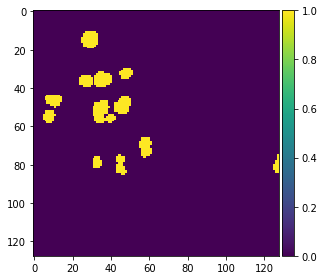

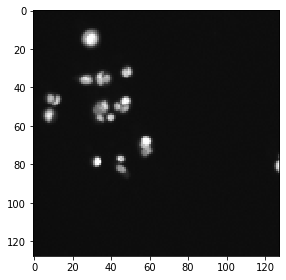

1/1 [==============================] - 0s 2ms/step


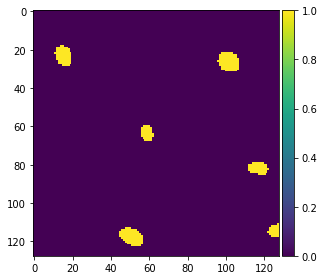

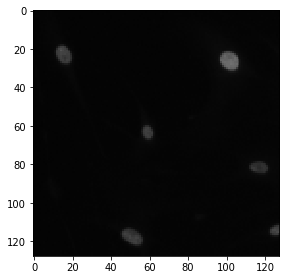

1/1 [==============================] - 0s 1ms/step


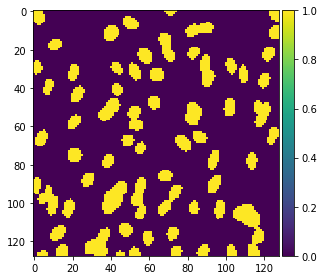

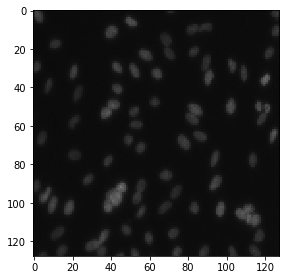

1/1 [==============================] - 0s 3ms/step


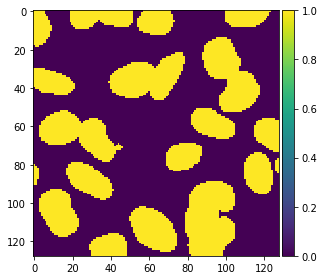

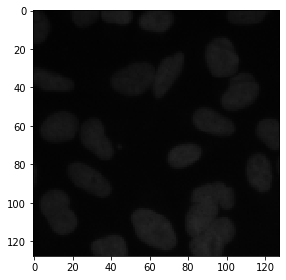

1/1 [==============================] - 0s 2ms/step


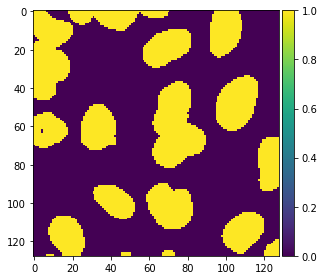

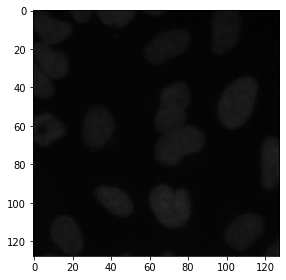

1/1 [==============================] - 0s 1ms/step


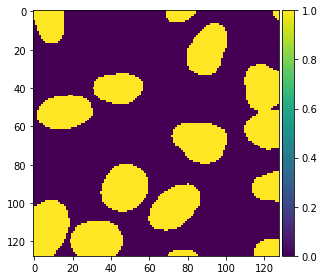

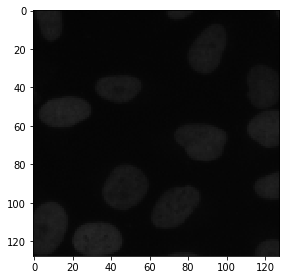

1/1 [==============================] - 0s 1ms/step


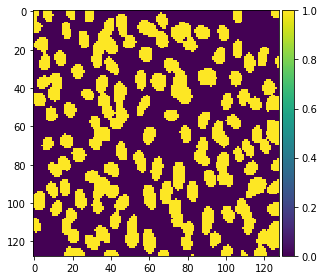

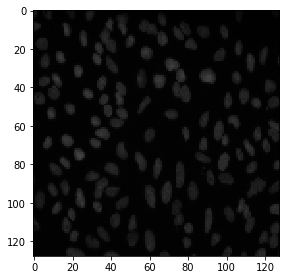

In [63]:
for i in range(8):
  idx = random.randint(10, len(x_train))
  x=np.array(x_train[idx])
  x=np.expand_dims(x, axis=0)
  predict = model.predict(x, verbose=1)
  predict = (predict > 0.5).astype(np.uint8)
  imshow(np.squeeze(predict[0]))
  plt.show()
  imshow(x_train[idx])
  plt.show()

## Four Changes that i have made on the UNET Architecture
###  1. No. of. Convolution Layers 
Depending upon how large your dataset is, the CNN architecture is implemented. Adding layers unnecessarily to any CNN will increase your number of parameters only for the smaller dataset. It’s true for some reasons that on adding more hidden layers, it will give more accuracy. This is true for larger datasets, as more layers with less stride factor will extract more features for your input data. In CNN, how you play with your architecture is completely dependent on what your requirement is and how your data is. There is term called “Overfitting” and “Underfitting”. Increasing Unnecessary parameters will only overfit your network. **In this architecture, i have added first layer i.e, c0 with filter of size 8 and kernal of (3,3), relu activation function with dropout rate 30%. Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.**
###  2. Dropout Layers
Dropout is a technique to fight overfitting and improve neural network generalization. So the good starting point is to focus on training performance, and deal with overfitting once you clearly see it. 

1.    CONV-1: filter=3x3, size=32, dropout between 0.0-0.1
2.    CONV-2: filter=3x3, size=64, dropout between 0.1-0.25
3.    CONV-3: filter=3x3, size=128, dropout between 0.2-0.3 


###  3. Activation Function
In UNET Architecture, i have changed **elu** activation function to **relu** since it improve neural networks is by speeding up training. The gradient computation is very simple (either 0 or 1 depending on the sign of x). Also, the computational step of a ReLU is easy: any negative elements are set to 0.0, no exponentials, no multiplication or division operations. It avoids and rectifies *vanishing gradient problem.*

**relu activation** With default values, this returns the standard ReLU activation: max(x, 0), the element-wise maximum of 0 and the input tensor.Modifying default parameters allows you to use non-zero thresholds, change the max value of the activation, and to use a non-zero multiple of the input for values below the threshold. Since the problem with **elu** was if x > 0, it can blow up the activation with the output range of [0, inf].

*tf.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0)*


###  4. Optimzers
In this architecture i have changed *adam* to optimizer to *rmsprop* since
Gradients of very complex functions like neural networks have a tendency to either vanish or explode as the energy is propagated through the function. rmsprop is a very clever way to deal with the problem. It uses a moving average of squared gradients to normalize the gradient itself. That has an effect of balancing the step size — decrease the step for large gradient to avoid exploding, and increase the step for small gradient to avoid vanishing.


## Conclusions
**Existing Model(in class):**
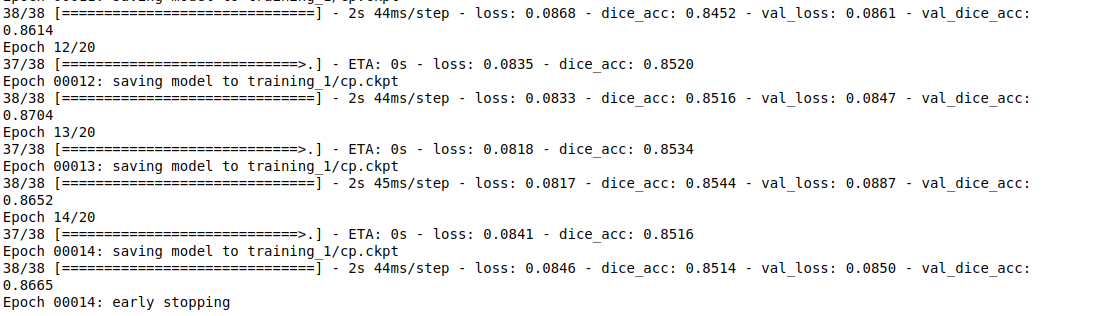


**Modified Model**
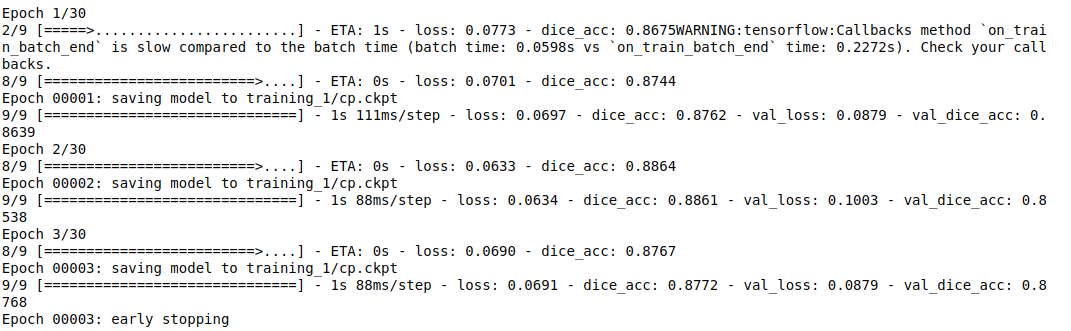
 
 
